Background of script
--

Because LC did not map introns clusters to genes, we have to do it ourselves.

Assign gene names (to get strand and protein coding only), and assign maxent scores

Regions with overlapping genes: have to go by maxent score (which over one is positive: 5' or 3')




In [5]:
from Bio.Seq import Seq

import numpy as np

import pandas as pd

import seaborn as sns
sns.set_context('poster')
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from SplicingStats.MaxEnt import MaxEnt
import pybedtools
hsv_pal=sns.color_palette('hsv', as_cmap=False)
from pyensembl import EnsemblRelease


sns.set_context('poster') 
plt.rcParams["font.family"] = 'arial'

plt.rcParams["font.variant"]='small-caps'

plt.rcParams["font.size"]='30'
hsv_pal=sns.color_palette('hsv', as_cmap=False)

In [6]:
sns.set_context('poster')

Load data
--

In [7]:
data_directory='/Users/hannahjacobs/Dropbox (MIT)/GradSchool/Finucane/splicing_variation_in_humans_2022/data/01_data/new_results/'


load alt splice site files
--

In [13]:




top_EF_5_across_all_tissues=pd.read_csv(data_directory+'top_EF_all_tissues_alt_ss.csv.gz',
                               compression='gzip')

all_EF_df_meets_five_percent_PSI_cutoff=pd.read_csv(data_directory+'all_EF_all_tissues_alt_ss.csv.gz',
                               compression='gzip')



Functions required for filtering alt ss
--

In [17]:
def assign_four_splice_sites(all_EF_df_meets_five_percent_PSI_cutoff):
    adj=1
    
    ss_a = all_EF_df_meets_five_percent_PSI_cutoff.intron_1.apply(lambda x: int(x.split(':')[1]))
    #add 1
    ss_b = all_EF_df_meets_five_percent_PSI_cutoff.intron_1.apply(lambda x: int(x.split(':')[2])-adj)
    #add 1
    ss_c = all_EF_df_meets_five_percent_PSI_cutoff.intron_2.apply(lambda x: int(x.split(':')[1]))
    ss_d = all_EF_df_meets_five_percent_PSI_cutoff.intron_2.apply(lambda x: int(x.split(':')[2])-adj)

    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_a=ss_a)
    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_b=ss_b)

    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_c=ss_c)
    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_d=ss_d)
    
    return all_EF_df_meets_five_percent_PSI_cutoff

def define_constant_minority_majority_ss(df):
    
    strand=df.strand.iloc[1]
    type_ss=df.splicing_event.iloc[1]
    
    adj=1

    if type_ss=='alt_3_prime':
        
        if strand=='+':
            
            df=df.rename(columns={'ss_d':'majority_ss',
                                           'ss_b': 'minority_ss',
                                           'ss_a': 'constant_ss'
                                          })

            minority_ss_start = df['minority_ss'] - 20  - adj #done

            minority_ss_end = df['minority_ss'] + 3  -adj#done

            majority_ss_start = df['majority_ss'] - 20 -adj#done

            majority_ss_end = df['majority_ss'] +3 -adj #done
                                  

            
        elif strand=='-':
            
            
            df=df.rename(columns={'ss_c':'majority_ss',
                                           'ss_a': 'minority_ss',
                                           'ss_b': 'constant_ss',   
                                          })
            #leafcutter adjustment
       
            minority_ss_start = df['minority_ss'] - 3    #done
            minority_ss_end = df['minority_ss'] + 20  #done

            majority_ss_start = df['majority_ss'] - 3  #done

            majority_ss_end = df['majority_ss'] + 20  #done
                                  
  #######ALT 5 PRIME#########         
    elif type_ss=='alt_5_prime':
        
        if strand=='+':
            
            df=df.rename(columns={'ss_c':'majority_ss',
                                           'ss_a': 'minority_ss',
                                           'ss_b': 'constant_ss'
                                          })

            minority_ss_start = df['minority_ss'] - 3 #done

            minority_ss_end = df['minority_ss'] + 6 #done

            majority_ss_start = df['majority_ss'] - 3 #done

            majority_ss_end = df['majority_ss'] + 6 #done
                                  
      
        elif strand=='-':
            
  
            df=df.rename(columns={'ss_d':'majority_ss',
                                           'ss_b': 'minority_ss',
                                           'ss_a': 'constant_ss',
                             
                                          })
          
            minority_ss_start = df['minority_ss'] - 3 - 4

            minority_ss_end = df['minority_ss'] + 6 - 4

            majority_ss_start = df['majority_ss'] - 3 - 4

            majority_ss_end = df['majority_ss'] + 6 - 4
            
                
        

    df=df.assign(minority_ss_start=minority_ss_start)
    df=df.assign(minority_ss_end=minority_ss_end)
    
    
    df=df.assign(majority_ss_start=majority_ss_start)
    df=df.assign(majority_ss_end=majority_ss_end)
    
    return df
            




            
def get_fasta_for_ss(df, type_ss):
    df=df.assign(chromosome=df.cluster_name.apply(lambda x: x.split(':')[0]))
    for_fasta = df[['chromosome', type_ss+'_start', type_ss+'_end', 'strand']]

    strand=df.strand.iloc[1]

    a = pybedtools.BedTool.from_dataframe(for_fasta)
    
    fasta = pybedtools.example_filename('/Users/hannahjacobs/Dropbox (MIT)/GradSchool/Finucane/splicing_variation_in_humans_2022/data/annotations/fasta_hg38/hg38.fa')
    
    a = a.sequence(fi=fasta, s=True)

    fastas=open(a.seqfn).read()

    seqs=fastas.split('\n')[1::2]
    seqs=[sequence.upper() for sequence in seqs]
    
    

    regions=fastas.split('\n')[0:-1:2]
    fastas = pd.DataFrame({'regions' : regions,
                                'fastas' : seqs})  
    if strand=='-':
        reverse_comp=fastas.fastas.apply(lambda x: ''.join(Seq(x).reverse_complement()))

        fastas = pd.DataFrame({'regions' : regions,
                                'fastas' : reverse_comp})  
    return fastas


def compute_maxent_on_data(df, ss_list_flag):
    compute_maxent=MaxEnt()
    
    if ss_list_flag=='alt_splicing':
        
        ss_list=['constant_ss', 'minority_ss', 'majority_ss']


        
        for ss in ss_list:
            df_w_fastas=get_fasta_for_ss(df, ss)
        
            fasta_ss_seq = df_w_fastas.fastas
            
            if ss=='minority_ss':
                df=df.assign(minor_ss_seq=list(fasta_ss_seq))
            if ss=='majority_ss':
                df=df.assign(major_ss_seq=list(fasta_ss_seq))
            if ss=='constant_ss':
                df=df.assign(constant_ss_seq=list(fasta_ss_seq))
    
        
            maxent_scores = compute_maxent.compute_score(df_w_fastas['fastas'].values)
    
            df[ss+'_maxent_score']=maxent_scores

    elif ss_list_flag=='skipped_exon':

        ss_list=['majority_ss_1', 'majority_ss_2', 'minority_ss_1', 'minority_ss_2']

        
            
        for ss in ss_list:
        

            df_w_fastas=get_fasta_for_ss(df, ss)

            fasta_ss_seq = df_w_fastas.fastas

            if ss=='majority_ss_1':
                df=df.assign(majority_ss_1_seq=list(fasta_ss_seq))
            if ss=='majority_ss_2':
                df=df.assign(majority_ss_2_seq=list(fasta_ss_seq))
            if ss=='minority_ss_1':
                df=df.assign(minority_ss_1_seq=list(fasta_ss_seq))
            if ss=='minority_ss_2':
                df=df.assign(minority_ss_2_seq=list(fasta_ss_seq))
                
            maxent_scores = compute_maxent.compute_score(df_w_fastas['fastas'].values)

            df[ss+'_maxent_score']=maxent_scores
        

        

    
    return df


def try_all_ss_alt_ss(df):
    ####### positive strand
        
        df=df.assign(strand='+')
        
    # as 3' splice site
        as_3_pos=df.assign(splicing_event='alt_3_prime')
    
        
        as_3_pos=define_constant_minority_majority_ss(as_3_pos)

        
        as_three_prime_pos=compute_maxent_on_data(as_3_pos, 'alt_splicing')

    # as 5' splice site
        as_five_pos=df.assign(splicing_event='alt_5_prime')

        
        as_five_pos=define_constant_minority_majority_ss(as_five_pos)

  
        
        as_five_prime_pos=compute_maxent_on_data(as_five_pos, 'alt_splicing')
        
######### negative strand #########
        df=df.assign(strand='-')

# as 3' splice site
        as_3_neg=df.assign(splicing_event='alt_3_prime')
    
        
        as_3_neg=define_constant_minority_majority_ss(as_3_neg) 

    
        as_three_prime_neg=compute_maxent_on_data(as_3_neg, 'alt_splicing')
        
    
 # as 5' splice site
        as_5_neg=df.assign(splicing_event='alt_5_prime')
        

        as_5_neg=define_constant_minority_majority_ss(as_5_neg)

        
        as_five_prime_neg=compute_maxent_on_data(as_5_neg, 'alt_splicing')


        return as_five_prime_pos , as_three_prime_pos, as_five_prime_neg , as_three_prime_neg

def passed_threshold(df, type):
    if type=='alt_ss':
        
        passed_bool=((df.minority_ss_maxent_score>0) * (df.majority_ss_maxent_score>0) * (df.constant_ss_maxent_score>0))
        greater_than_zero=(df.majority_ss - df.minority_ss).abs() > 0 
    elif type=='SE':
            passed_bool=(df[['majority_ss_1_maxent_score', 'majority_ss_2_maxent_score', 'minority_ss_1_maxent_score',	'minority_ss_2_maxent_score']]>0).sum(axis=1)==4

            greater_than_zero = True
    return passed_bool * greater_than_zero

def assign_four_splice_sites(all_EF_df_meets_five_percent_PSI_cutoff):
    adj=1
    
    ss_a = all_EF_df_meets_five_percent_PSI_cutoff.intron_1.apply(lambda x: int(x.split(':')[1]))
    #add 1
    ss_b = all_EF_df_meets_five_percent_PSI_cutoff.intron_1.apply(lambda x: int(x.split(':')[2])-adj)
    #add 1
    ss_c = all_EF_df_meets_five_percent_PSI_cutoff.intron_2.apply(lambda x: int(x.split(':')[1]))
    
    ss_d = all_EF_df_meets_five_percent_PSI_cutoff.intron_2.apply(lambda x: int(x.split(':')[2])-adj)

    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_a=ss_a)
    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_b=ss_b)

    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_c=ss_c)
    all_EF_df_meets_five_percent_PSI_cutoff=all_EF_df_meets_five_percent_PSI_cutoff.assign(ss_d=ss_d)
    
    return all_EF_df_meets_five_percent_PSI_cutoff

    
def define_constant_minority_majority_ss(df):
    
    strand=df.strand.iloc[1]
    type_ss=df.splicing_event.iloc[1]
    
 

    if type_ss=='alt_3_prime':
        
        if strand=='+':
            
            df=df.rename(columns={'ss_d':'majority_ss',
                                           'ss_b': 'minority_ss',
                                           'ss_a': 'constant_ss'
                                          })

            minority_ss_start = df['minority_ss'] - 20  #done

            minority_ss_end = df['minority_ss'] + 3  #done

            majority_ss_start = df['majority_ss'] - 20#done

            majority_ss_end = df['majority_ss'] +3  #done
                                  
            constant_ss_start = df['constant_ss'] - 3

            constant_ss_end = df['constant_ss'] + 6  
                                  
            
        elif strand=='-':
            
            
            df=df.rename(columns={'ss_a':'minority_ss',
                                           'ss_c': 'majority_ss',
                                           'ss_b': 'constant_ss',   
                                          })
            #leafcutter adjustment
       
            minority_ss_start = df['minority_ss'] - 3    #done
            minority_ss_end = df['minority_ss'] + 20  #done

            majority_ss_start = df['majority_ss'] - 3  #done

            majority_ss_end = df['majority_ss'] + 20  #done

            constant_ss_start = df['constant_ss'] - 6

            constant_ss_end = df['constant_ss'] + 3  
                                  
  #######ALT 5 PRIME#########         
    elif type_ss=='alt_5_prime':
        
        if strand=='+':
            
            df=df.rename(columns={'ss_c':'majority_ss',
                                           'ss_a': 'minority_ss',
                                           'ss_b': 'constant_ss'
                                          })

            minority_ss_start = df['minority_ss'] - 3 #done

            minority_ss_end = df['minority_ss'] + 6 #done

            majority_ss_start = df['majority_ss'] - 3 #done

            majority_ss_end = df['majority_ss'] + 6 #done
                                  
            constant_ss_start = df['constant_ss'] - 20

            constant_ss_end = df['constant_ss'] + 3  

        
        elif strand=='-':
            
  
            df=df.rename(columns={'ss_d':'majority_ss',
                                           'ss_b': 'minority_ss',
                                           'ss_a': 'constant_ss',
                             
                                          })

            minority_ss_start = df['minority_ss'] - 6 

            minority_ss_end = df['minority_ss'] + 3 

            majority_ss_start = df['majority_ss'] - 6 
            majority_ss_end = df['majority_ss'] + 3 

            constant_ss_start = df['constant_ss'] - 3

            constant_ss_end = df['constant_ss'] + 20 
                
        

    df=df.assign(minority_ss_start=minority_ss_start)
    df=df.assign(minority_ss_end=minority_ss_end)
    
    
    df=df.assign(majority_ss_start=majority_ss_start)
    df=df.assign(majority_ss_end=majority_ss_end)

    df=df.assign(constant_ss_start=constant_ss_start)
    df=df.assign(constant_ss_end=constant_ss_end)
    
    return df
            



def plot_scores(df):
    plt.subplots_adjust(wspace=0.4, hspace=0)
    f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True, 
                                     figsize=(30/1.5,6/1.5))

    if df.splicing_event.iloc[0]=='alt_5_prime':
        constant_ss='alt_3_prime'
    else:
        constant_ss='alt_5_prime'
    
    ax=sns.histplot(df.constant_ss_maxent_score, ax=ax1, color='black')
    ax.set_title('constant is '+ str(df.strand.iloc[1]+ ' '+constant_ss))
    
        
    ax1=sns.histplot(df.majority_ss_maxent_score, ax=ax2, color='black')
    ax1.set_title('cognate is '+str(df.strand.iloc[1])+ ' ' + str(df.splicing_event.iloc[1]))
        
    ax2=sns.histplot(df.minority_ss_maxent_score, ax=ax3, color='black')
    
    ax2.set_title('NVE is '+str(df.strand.iloc[1])+ ' ' + str(df.splicing_event.iloc[1]))        
    ax.set_xlabel('maxent score')
    ax1.set_xlabel('maxent score')
    ax3.set_xlabel('maxent score')
    ax2.set_xlabel('maxent score')

assign gene names and maxent scores to ALT SPLICE SITES
--

1. assign maxent scores
--

In [18]:
top_EF_5_across_all_tissues=assign_four_splice_sites(top_EF_5_across_all_tissues)

run maxent
--

In [19]:
[as_five_prime_pos , as_three_prime_pos, as_five_prime_neg , as_three_prime_neg]= try_all_ss_alt_ss(top_EF_5_across_all_tissues)

;

n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n
n


''

a. Supplemental plot of all scores
--

<Figure size 640x480 with 0 Axes>

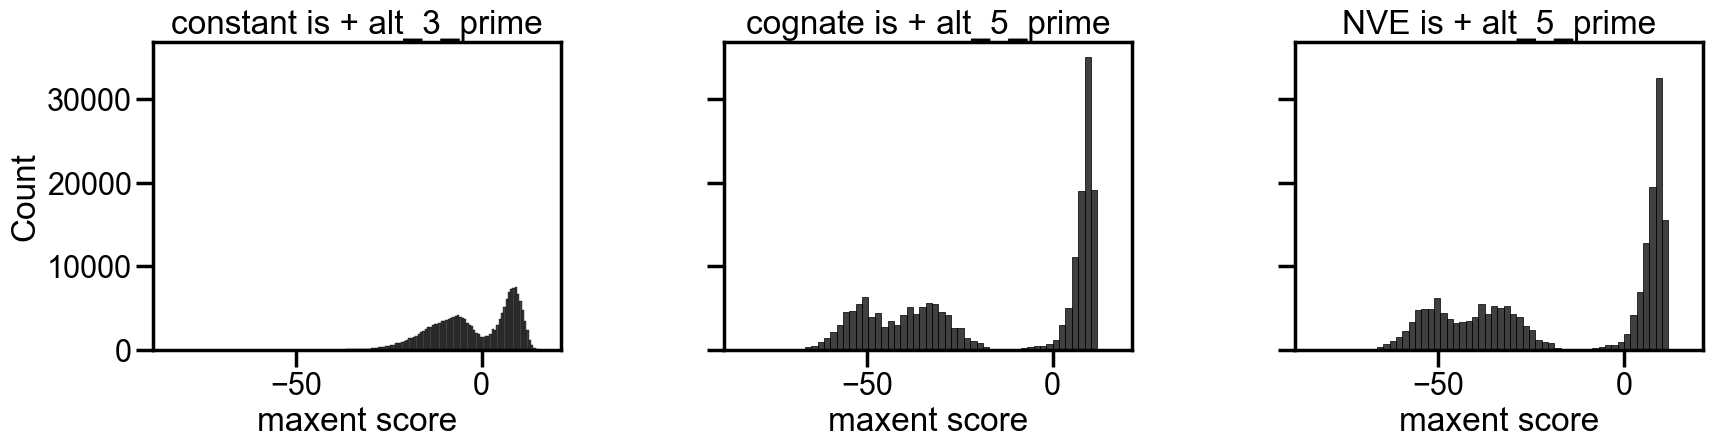

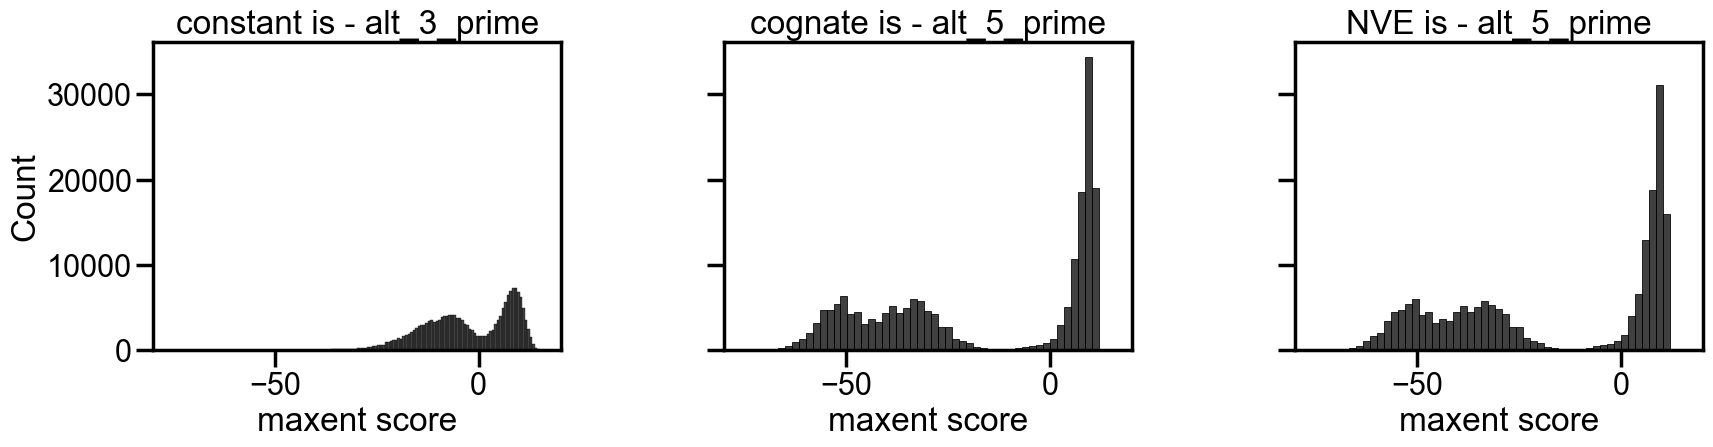

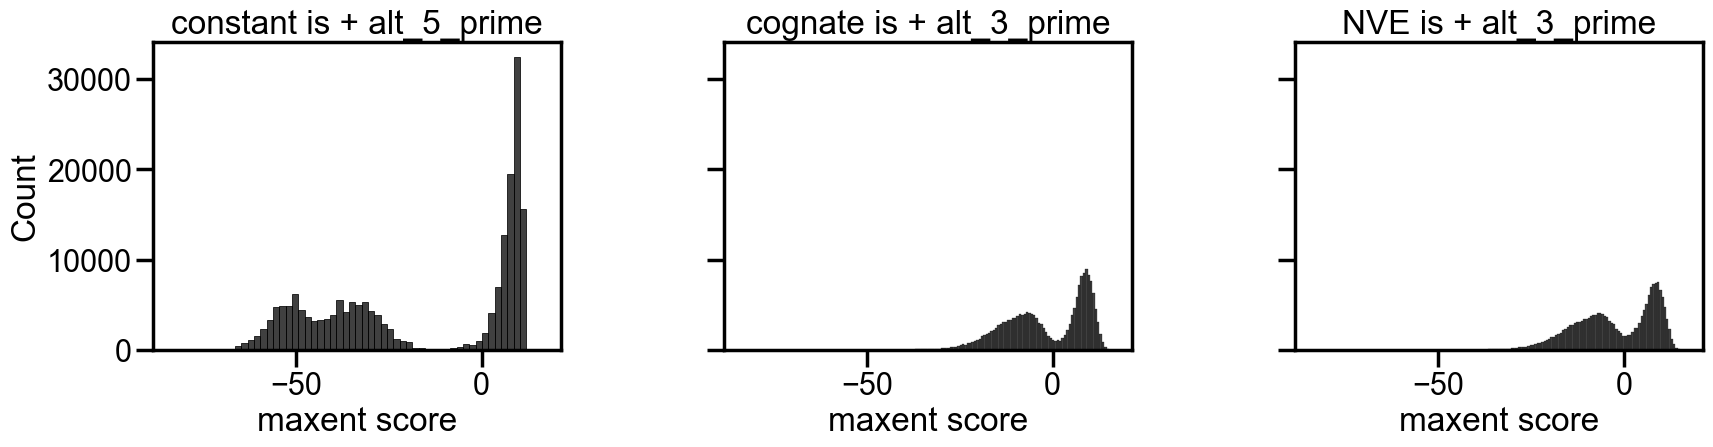

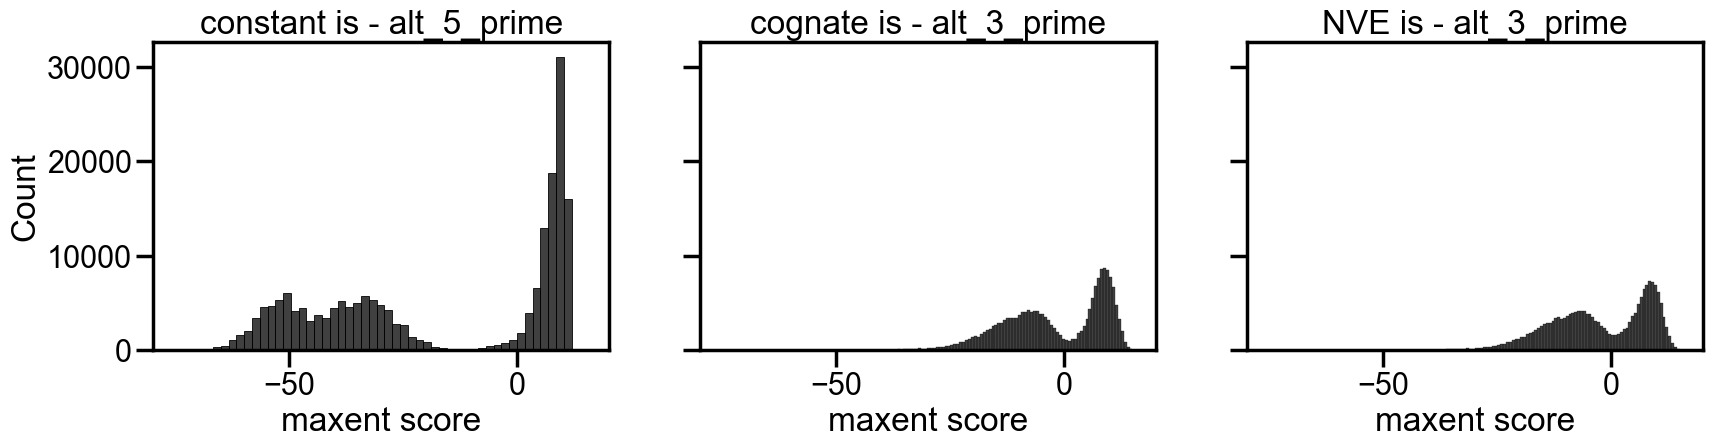

In [20]:
plot_scores(as_five_prime_pos)
plot_scores(as_five_prime_neg)
plot_scores(as_three_prime_pos)
plot_scores(as_three_prime_neg)

Assign strand and splicing event based on maxent score
--

Figure out which % passes the threshold: 93%

In [21]:
as_five_prime_pos_passed=as_five_prime_pos[passed_threshold(as_five_prime_pos,'alt_ss') ]# ((as_five_prime_pos.constant_ss_maxent_score) > (as_three_prime_pos.constant_ss_maxent_score))]

as_three_prime_pos_passed=as_three_prime_pos[passed_threshold(as_three_prime_pos,'alt_ss') ]# & ((as_five_prime_pos.constant_ss_maxent_score) < (as_three_prime_pos.constant_ss_maxent_score))]

as_five_prime_neg_passed=as_five_prime_neg[passed_threshold(as_five_prime_neg, 'alt_ss') ]#& ((as_five_prime_neg.constant_ss_maxent_score) > (as_three_prime_neg.constant_ss_maxent_score))]

as_three_prime_neg_passed=as_three_prime_neg[passed_threshold(as_three_prime_neg,'alt_ss') ]#& ((as_five_prime_neg.constant_ss_maxent_score) < (as_three_prime_neg.constant_ss_maxent_score))]
 



assigned_a_splice_site = len(as_five_prime_pos_passed)+len(as_three_prime_pos_passed)+len(as_five_prime_neg_passed)+len(as_three_prime_neg_passed)

#percent that scored at least 0
assigned_a_splice_site/len(top_EF_5_across_all_tissues)


0.9349920837134199

Assign exon lengths
--

In [89]:

exon_length_n = (as_five_prime_neg_passed.minority_ss - as_five_prime_neg_passed.majority_ss) 

exon_length_p = (as_five_prime_pos_passed.majority_ss - as_five_prime_pos_passed.minority_ss) 

as_five_prime_pos_passed=as_five_prime_pos_passed.assign(exon_length=exon_length_p)

as_five_prime_neg_passed=as_five_prime_neg_passed.assign(exon_length=exon_length_n)

exon_length=pd.concat([exon_length_p, exon_length_n])





In [90]:
exon_length_n = (as_three_prime_neg_passed.minority_ss - as_three_prime_neg_passed.majority_ss) 

exon_length_p = (as_three_prime_pos_passed.majority_ss - as_three_prime_pos_passed.minority_ss) 


as_three_prime_pos_passed=as_three_prime_pos_passed.assign(exon_length=exon_length_p)

as_three_prime_neg_passed=as_three_prime_neg_passed.assign(exon_length=exon_length_n)






In [91]:
top_events_assigned_by_maxent = pd.concat([as_five_prime_pos_passed, as_three_prime_pos_passed, as_five_prime_neg_passed, as_three_prime_neg_passed])


Filter for alt splice sites less than 500bp
--

In [93]:
top_events_assigned_by_maxent_under_500bp=top_events_assigned_by_maxent[top_events_assigned_by_maxent.exon_length.abs()<=500]

top_events_assigned_by_maxent_under_500bp=top_events_assigned_by_maxent_under_500bp.assign(chromosome=top_events_assigned_by_maxent_under_500bp.cluster_name.apply(lambda x: x.split(':')[0]))

df=top_events_assigned_by_maxent_under_500bp

Assign gene names
--

In [95]:
# release 77 uses human reference genome GRCh38
data = EnsemblRelease(102)

chromosome=df.cluster_name.apply(lambda x: (x.split(':')[0]))

chrom_only_value=df.chromosome.apply(lambda x: (x.split('chr')[1]))



df=df.assign(chrom_only_value=chrom_only_value)


# will return ['HLA-A']
gene_names = df.apply(lambda x: data.genes_at_locus(contig=x['chrom_only_value'], position=x['majority_ss_start'], end=x['majority_ss_end'], strand=x['strand']), axis=1)
   

has_at_least_one_gene=gene_names.apply(lambda x: len(x)>0)

df=df[list(has_at_least_one_gene)]



name = gene_names[has_at_least_one_gene].apply(lambda x: x[0].gene_name)

biotype = gene_names[has_at_least_one_gene].apply(lambda x: x[0].biotype)

strand = gene_names[has_at_least_one_gene].apply(lambda x: x[0].strand)



df=df.assign(biotype=biotype)

df=df.assign(gene_name=name)


protein_coding_genes_maxent_filtered_AS= df[df.biotype=='protein_coding']




sum stats
--

In [96]:


print('top EF alt ss# after filtering = '+str(len(protein_coding_genes_maxent_filtered_AS)))

top EF alt ss# after filtering = 34067


SKIPPED EXONS
--

functions required for filtering skipped exons
--

In [97]:
def assign_splice_based_on_strand(df, intron_1, intron_2):
    df=df.assign(intron_1=df[intron_1])

    df=df.assign(intron_2=df[intron_2])
    return df
def define_SE_minority_majority_ss(df):
    
    strand=df.strand.iloc[1]
    type_ss=df.minority_is_exclusion_event.iloc[1]
    
 

    if type_ss==True:
        
        if strand=='+':
               #minority is exclusion
            df=df.rename(columns={'ss_b':'majority_ss_1',
                                           'ss_c': 'majority_ss_2',
                                           'ss_a': 'minority_ss_1',
                                            'ss_d': 'minority_ss_2'
                                          })
                                  
            minority_ss_1_start = df['minority_ss_1'] - 3

            minority_ss_1_end = df['minority_ss_1'] + 6  


            majority_ss_1_start = df['majority_ss_1'] - 20  

            majority_ss_1_end = df['majority_ss_1'] + 3

            
            majority_ss_2_start = df['majority_ss_2'] -3  

            majority_ss_2_end = df['majority_ss_2'] + 6

                    
            minority_ss_2_start = df['minority_ss_2'] - 20  

            minority_ss_2_end = df['minority_ss_2'] + 3



                                  
            
        elif strand=='-':
            
            df=df.rename(columns={'ss_b':'majority_ss_1',
                                           'ss_c': 'majority_ss_2',
                                           'ss_a': 'minority_ss_1',
                                            'ss_d': 'minority_ss_2'
                                          })
            minority_ss_1_start = df['minority_ss_1'] - 3

            minority_ss_1_end = df['minority_ss_1'] + 20  


            majority_ss_1_start = df['majority_ss_1'] - 6  

            majority_ss_1_end = df['majority_ss_1'] + 3

            
            majority_ss_2_start = df['majority_ss_2'] - 3  

            majority_ss_2_end = df['majority_ss_2'] + 20

                    
            minority_ss_2_start = df['minority_ss_2'] - 6  

            minority_ss_2_end = df['minority_ss_2'] + 3

 

    elif type_ss == False:
        
        if strand=='+':
            
               #minority is inclusion
            df=df.rename(columns={'ss_a':'majority_ss_1',
                                           'ss_d': 'majority_ss_2',
                                           'ss_b': 'minority_ss_1',
                                            'ss_c': 'minority_ss_2'
                                          })
                                  
            majority_ss_1_start = df['majority_ss_1'] - 3

            majority_ss_1_end = df['majority_ss_1'] + 6  


            minority_ss_1_start = df['minority_ss_1'] - 20  

            minority_ss_1_end = df['minority_ss_1'] + 3

            
            minority_ss_2_start = df['minority_ss_2'] -3  

            minority_ss_2_end = df['minority_ss_2'] + 6

                    
            majority_ss_2_start = df['majority_ss_2'] - 20  

            majority_ss_2_end = df['majority_ss_2'] + 3


        
        elif strand=='-':
            
  
            df=df.rename(columns={'ss_b':'minority_ss_1',
                                           'ss_c': 'minority_ss_2',
                                           'ss_a': 'majority_ss_1',
                                            'ss_d': 'majority_ss_2'
                                          })
            majority_ss_1_start = df['majority_ss_1'] - 3

            majority_ss_1_end = df['majority_ss_1'] + 20  


            minority_ss_1_start = df['minority_ss_1'] - 6  

            minority_ss_1_end = df['minority_ss_1'] + 3

            
            minority_ss_2_start = df['minority_ss_2'] - 3  

            minority_ss_2_end = df['minority_ss_2'] + 20

                    
            majority_ss_2_start = df['majority_ss_2'] - 6  

            majority_ss_2_end = df['majority_ss_2'] + 3
                
        

    df=df.assign(majority_ss_1_start=majority_ss_1_start)
    df=df.assign(majority_ss_1_end=majority_ss_1_end)
    

    df=df.assign(majority_ss_2_start=majority_ss_2_start)
    df=df.assign(majority_ss_2_end=majority_ss_2_end)

    df=df.assign(minority_ss_1_start=minority_ss_1_start)
    df=df.assign(minority_ss_1_end=minority_ss_1_end)

    df=df.assign(minority_ss_2_start=minority_ss_2_start)
    df=df.assign(minority_ss_2_end=minority_ss_2_end)
    

    
    return df
            

def try_all_ss_skipped_exons(input_df):
    
        minority_is_exlcusion = input_df[input_df.minority_is_exclusion_event]

        minority_is_inlcusion = input_df[~input_df.minority_is_exclusion_event]
        
##############MAJORITY IS INCLUSION OF EXON##############
    ####### try positive strand, 

        as_pos_strand_exclusion=minority_is_exlcusion.assign(strand='+')
        as_pos_strand_exclusion=assign_splice_based_on_strand(as_pos_strand_exclusion, 'intron_1_unskipped', 'intron_2_unskipped')
        as_pos_strand_exclusion=assign_four_splice_sites(as_pos_strand_exclusion)
        
        as_pos_strand_exclusion=define_SE_minority_majority_ss(as_pos_strand_exclusion)

        
        pos_strand_exclusion=compute_maxent_on_data(as_pos_strand_exclusion, 'skipped_exon')
        
######### negative strand #########

        as_neg_strand_exclusion=minority_is_exlcusion.assign(strand='-')
        as_neg_strand_exclusion=assign_splice_based_on_strand(as_neg_strand_exclusion, 'intron_1_unskipped', 'intron_2_unskipped')
        as_neg_strand_exclusion=assign_four_splice_sites(as_neg_strand_exclusion)
        
        as_neg_strand_exclusion=define_SE_minority_majority_ss(as_neg_strand_exclusion)

        
        neg_strand_exclusion=compute_maxent_on_data(as_neg_strand_exclusion, 'skipped_exon')
        
##############MINORITY IS INCLUSION OF EXON##############
        as_pos_strand_inclusion=minority_is_inlcusion.assign(strand='+')

        as_pos_strand_inclusion=assign_splice_based_on_strand(as_pos_strand_inclusion, 'intron_1_unskipped', 'intron_2_unskipped')

        as_pos_strand_inclusion=assign_four_splice_sites(as_pos_strand_inclusion)
        
        as_pos_strand_inclusion=define_SE_minority_majority_ss(as_pos_strand_inclusion)

        
        pos_strand_inclusion=compute_maxent_on_data(as_pos_strand_inclusion, 'skipped_exon')
        
######### negative strand #########

        as_neg_strand_inclusion=minority_is_inlcusion.assign(strand='-')
        as_neg_strand_inclusion=assign_splice_based_on_strand(as_neg_strand_inclusion, 'intron_1_unskipped', 'intron_2_unskipped')
        as_neg_strand_inclusion=assign_four_splice_sites(as_neg_strand_inclusion) 
        
        as_neg_strand_inclusion=define_SE_minority_majority_ss(as_neg_strand_inclusion)

        
        neg_strand_inclusion=compute_maxent_on_data(as_neg_strand_inclusion, 'skipped_exon')
            
        
    
        return neg_strand_inclusion, pos_strand_inclusion, neg_strand_exclusion, pos_strand_exclusion



load skipped exon data
--

In [98]:
top_EF_all_tissues_skipped_exons=pd.read_csv(data_directory+'top_EF_all_tissues_se.csv.gz',
                                             compression='gzip',
                                             low_memory='False')

                                          

In [99]:
all_EF_all_tissues_skipped_exons= pd.read_csv(data_directory+'all_EF_all_tissues_se.csv.gz',
                                             compression='gzip',
                                             low_memory='False')



1. Assign maxent scores
--

In [100]:
[neg_strand_inclusion, pos_strand_inclusion, neg_strand_exclusion, pos_strand_exclusion] = try_all_ss_skipped_exons(top_EF_all_tissues_skipped_exons)




In [101]:

def plot_scores_SE(df):
    plt.subplots_adjust(wspace=0.4, hspace=0)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, sharex=True, 
                                     figsize=(30/1.3,6/1.3))

    if df.minority_is_exclusion_event.iloc[1]==False:
        type_ss='NVE (spliced out) is '

        if  df.strand.iloc[1]=='-':
            first_ss = '3 prime'
            second_ss = '5 prime'
            third_ss = '5 prime'
            fourth_ss = '3 prime'
        elif  df.strand.iloc[1]=='+':
            first_ss = '5 prime'
            second_ss = '3 prime'
            third_ss = '3 prime'
            fourth_ss = '5 prime'
    elif df.minority_is_exclusion_event.iloc[1]==True:
        type_ss='NVE (spliced in) is the'
        type_ss_2='Cognate is'
        if  df.strand.iloc[1]=='-':
            first_ss = '5 prime'
            second_ss = '3 prime'
            third_ss = '3 prime'
            fourth_ss = '5 prime'
        elif  df.strand.iloc[1]=='+':
            first_ss = '3 prime'
            second_ss = '5 prime'
            third_ss = '5 prime'
            fourth_ss = '3 prime'
    ax=sns.histplot(df.majority_ss_1_maxent_score, ax=ax1,  color='black')
    ax.set_title(type_ss+ ' '+ str(df.strand.iloc[1])+ ' ' + first_ss)
    
    ax1=sns.histplot(df.majority_ss_2_maxent_score, ax=ax2, color='black')
    ax1.set_title('cognate is ' +str(df.strand.iloc[1])+ ' ' + second_ss)
    
    ax2=sns.histplot(df.minority_ss_1_maxent_score, ax=ax3, color='black')
    ax2.set_title(  str(df.strand.iloc[1])+ ' ' + third_ss)
 
    ax3=sns.histplot(df.minority_ss_2_maxent_score, ax=ax4, color='black')
    ax3.set_title(str(df.strand.iloc[1])+ ' ' + fourth_ss)

    ax.set_xlabel('maxent score')
    ax1.set_xlabel('maxent score')
    ax3.set_xlabel('maxent score')
    ax2.set_xlabel('maxent score')

<Figure size 640x480 with 0 Axes>

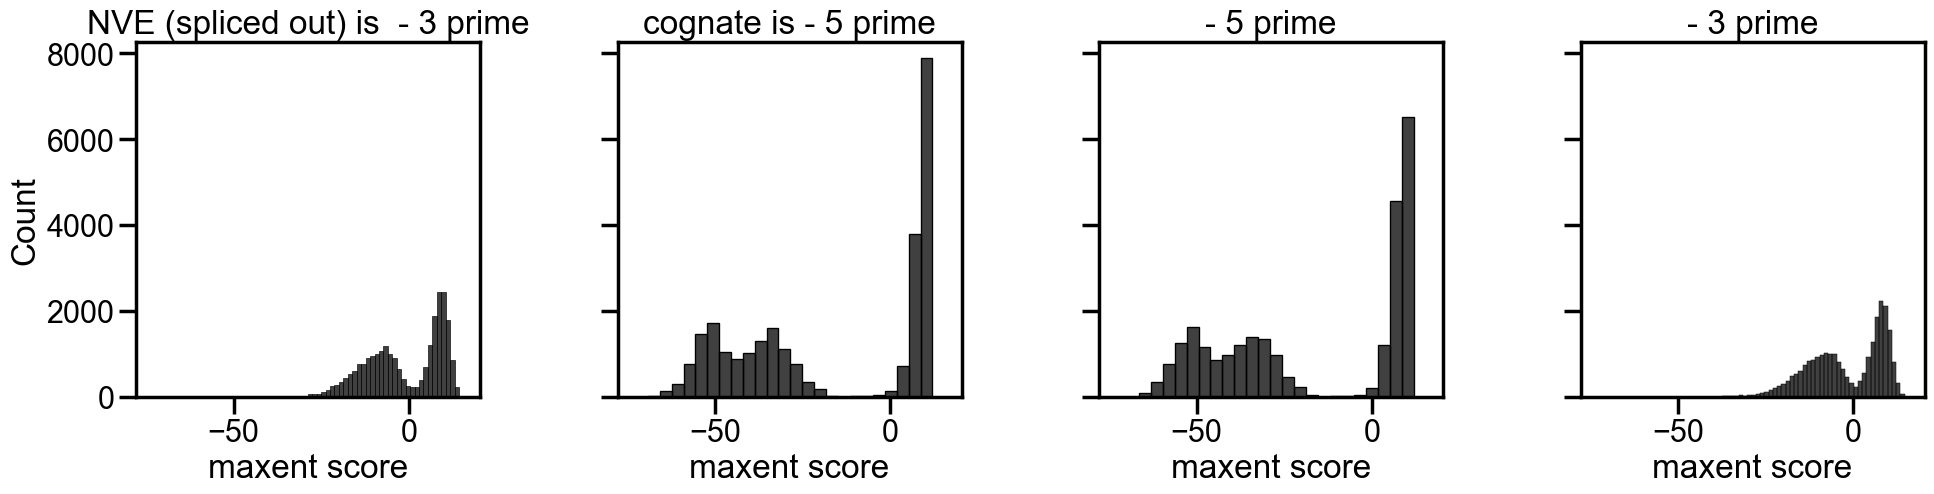

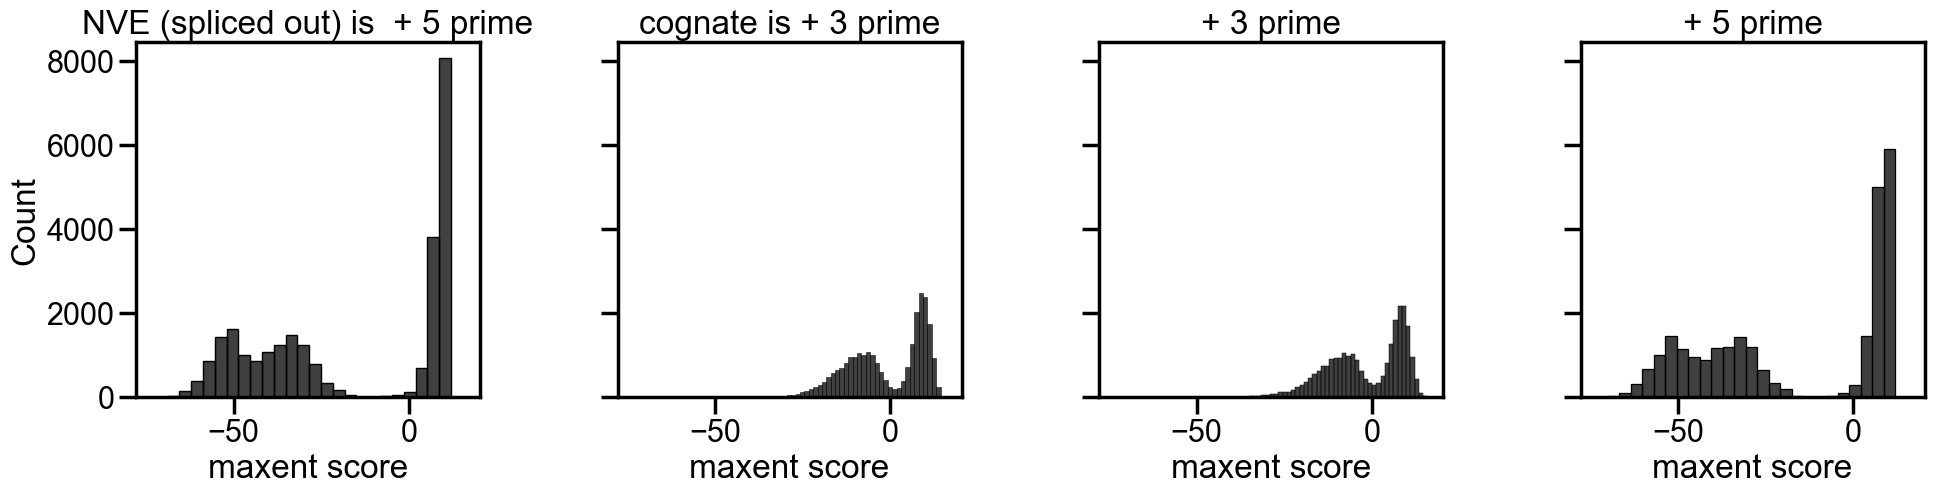

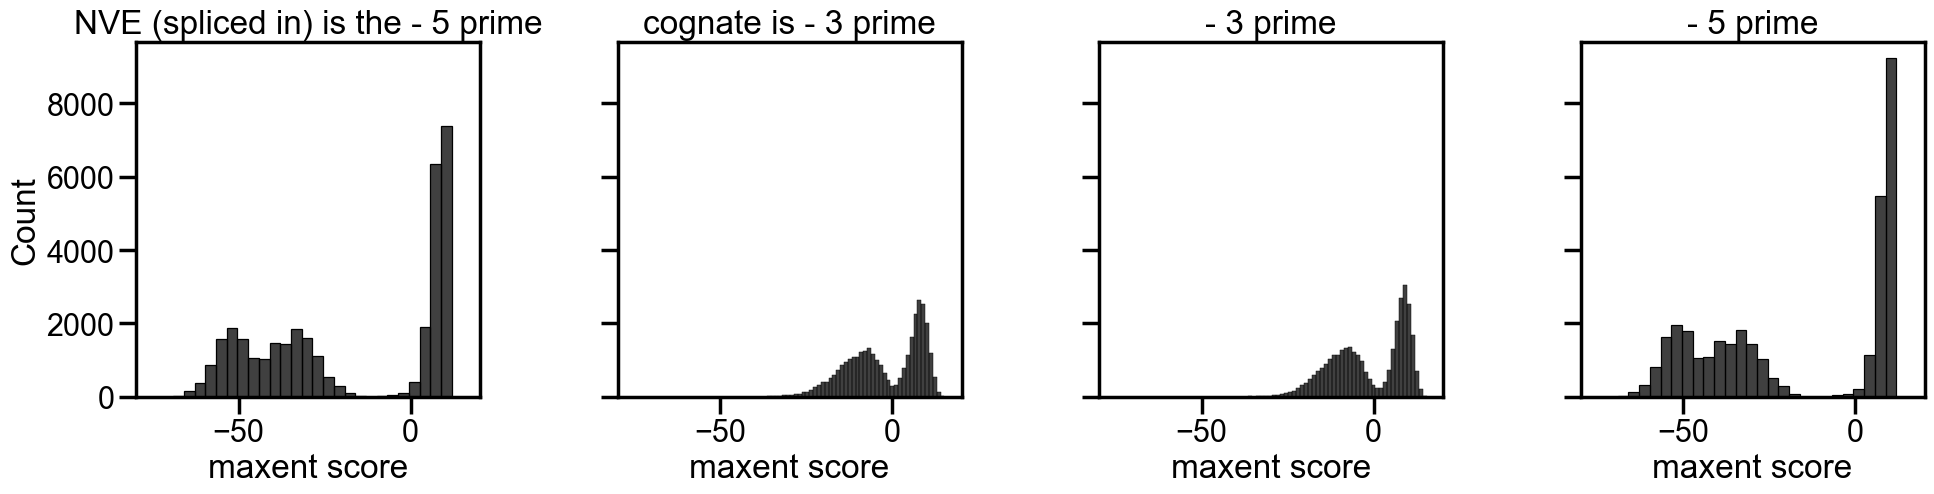

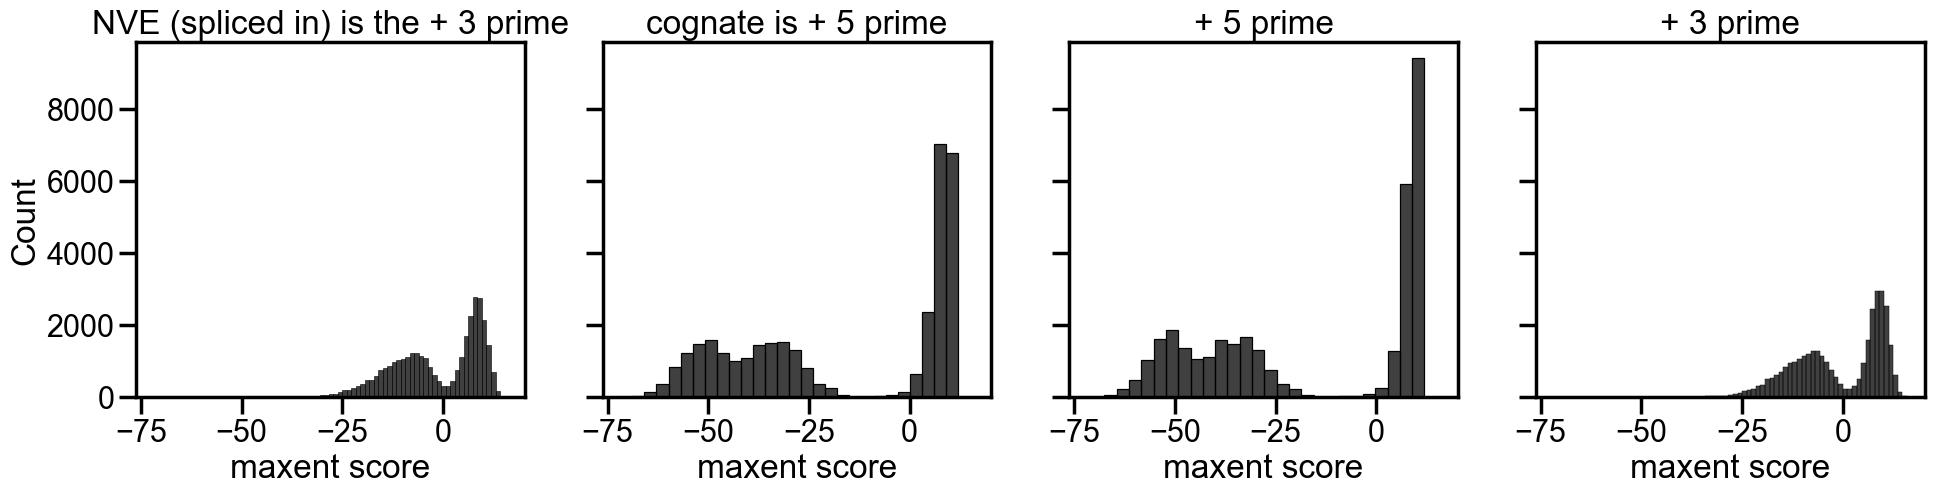

In [102]:
for ss in [neg_strand_inclusion, pos_strand_inclusion, neg_strand_exclusion, pos_strand_exclusion] :

    


    plot_scores_SE(ss)

2. assign passed based on maxent scores
--

In [37]:
neg_strand_inclusion, pos_strand_inclusion, neg_strand_exclusion, pos_strand_exclusion

neg_strand_inclusion_passed=neg_strand_inclusion[passed_threshold(neg_strand_inclusion, 'SE') ]# ((as_five_prime_pos.constant_ss_maxent_score) > (as_three_prime_pos.constant_ss_maxent_score))]

pos_strand_inclusion_passed=pos_strand_inclusion[passed_threshold(pos_strand_inclusion, 'SE') ]# & ((as_five_prime_pos.constant_ss_maxent_score) < (as_three_prime_pos.constant_ss_maxent_score))]

neg_strand_exclusion_passed=neg_strand_exclusion[passed_threshold(neg_strand_exclusion, 'SE') ]#& ((as_five_prime_neg.constant_ss_maxent_score) > (as_three_prime_neg.constant_ss_maxent_score))]

pos_strand_exclusion_passed=pos_strand_exclusion[passed_threshold(pos_strand_exclusion, 'SE') ]#& ((as_five_prime_neg.constant_ss_maxent_score) < (as_three_prime_neg.constant_ss_maxent_score))]
 



assigned_a_splice_site = len(neg_strand_inclusion_passed)+len(pos_strand_inclusion_passed)+len(neg_strand_exclusion_passed)+len(pos_strand_exclusion_passed)
#number skipped exons
assigned_a_splice_site/len(top_EF_all_tissues_skipped_exons)


0.9501527851277761

In [38]:
top_EF_all_tissues_skipped_exons_assigned_by_maxent=pd.concat([neg_strand_inclusion_passed, pos_strand_inclusion_passed, neg_strand_exclusion_passed, 
           pos_strand_exclusion_passed])


  

In [39]:
df = top_EF_all_tissues_skipped_exons_assigned_by_maxent

3. assign exon size, filter for 500 bp
--

In [40]:
df = top_EF_all_tissues_skipped_exons_assigned_by_maxent

SE_exon_length=df.apply(lambda row: row['majority_ss_2']-row['majority_ss_1'] if row['minority_is_exclusion_event']==True 
                     else row['minority_ss_2']-row['minority_ss_1'], axis=1).abs()

top_EF_all_tissues_skipped_exons_assigned_by_maxent=top_EF_all_tissues_skipped_exons_assigned_by_maxent.assign(SE_exon_length = SE_exon_length)



skipped_exons_500bp=top_EF_all_tissues_skipped_exons_assigned_by_maxent[top_EF_all_tissues_skipped_exons_assigned_by_maxent.SE_exon_length<=500]

In [ ]:
len(34067)


In [104]:
len(skipped_exons_500bp)

38538

In [105]:
skipped_exons_500bp=skipped_exons_500bp.assign(chromosome=skipped_exons_500bp.cluster_name.apply(lambda x: x.split(':')[0]))


4. Assign genes, filter for protein coding
--

In [106]:


df=skipped_exons_500bp

# release 77 uses human reference genome GRCh38
data = EnsemblRelease(102)

chromosome=df.cluster_name.apply(lambda x: (x.split(':')[0]))

chrom_only_value=df.chromosome.apply(lambda x: (x.split('chr')[1]))



df=df.assign(chrom_only_value=chrom_only_value)


# will return ['HLA-A']
gene_names = df.apply(lambda x: data.genes_at_locus(contig=x['chrom_only_value'], position=x['majority_ss_1_end'], end=x['majority_ss_1_end'], strand=x['strand']), axis=1)
   

has_at_least_one_gene=gene_names.apply(lambda x: len(x)>0)

df=df[list(has_at_least_one_gene)]



name = gene_names[has_at_least_one_gene].apply(lambda x: x[0].gene_name)

biotype = gene_names[has_at_least_one_gene].apply(lambda x: x[0].biotype)

strand = gene_names[has_at_least_one_gene].apply(lambda x: x[0].strand)



df=df.assign(biotype=biotype)

df=df.assign(gene_name=name)


protein_coding_genes_maxent_filtered_SE= df[df.biotype=='protein_coding']




In [137]:
print('SEs after filtering '+str(len(protein_coding_genes_maxent_filtered_SE)))

SEs after filtering 31486


In [138]:
def plot_maxent_scores(df, minor, major):
    ax=sns.ecdfplot(data=df, x=df[minor], color='magenta', label='minority splice')

    ax=sns.ecdfplot(data=df, x=df[major], color='black',  label='majority splice')

    
    ax.set_xlim([0,12])
    ax.legend()
    ax.set_xlabel('maxent score')


In [139]:
excluded = top_EF_all_tissues_skipped_exons_assigned_by_maxent[top_EF_all_tissues_skipped_exons_assigned_by_maxent.minority_is_exclusion_event]

included = top_EF_all_tissues_skipped_exons_assigned_by_maxent[~top_EF_all_tissues_skipped_exons_assigned_by_maxent.minority_is_exclusion_event]



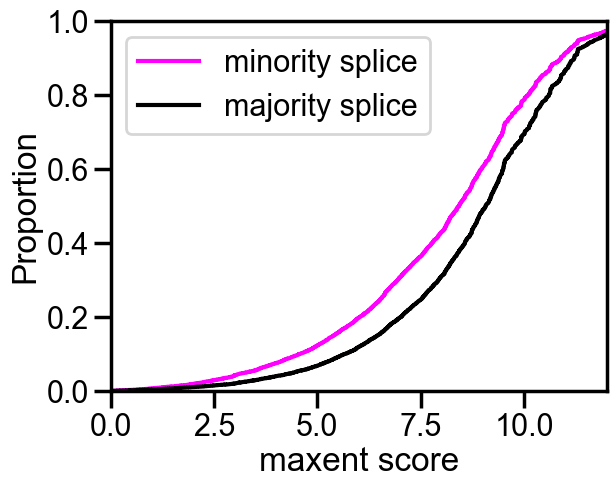

In [140]:
plot_maxent_scores(included,'minority_ss_1_maxent_score', 'majority_ss_1_maxent_score')

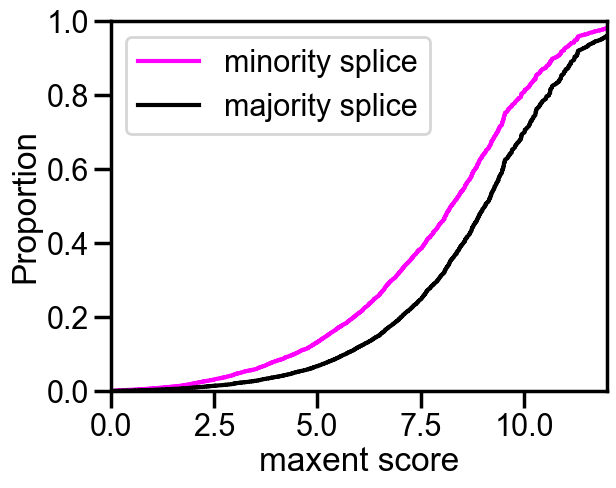

In [110]:
plot_maxent_scores(included,'minority_ss_2_maxent_score', 'majority_ss_2_maxent_score')

In [113]:
exclusion_event = protein_coding_genes_maxent_filtered_SE[protein_coding_genes_maxent_filtered_SE.minority_is_exclusion_event==True]

inclusion_event = protein_coding_genes_maxent_filtered_SE[protein_coding_genes_maxent_filtered_SE.minority_is_exclusion_event!=True]



In [114]:
sns.set_context('poster')
plt.rcParams["font.family"] = "arial"



Text(0.5, 0, 'size (bp) of NVE skipped exon')

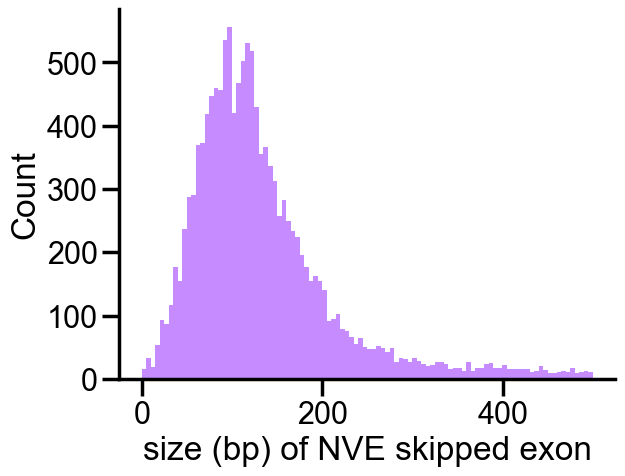

In [115]:
ax=sns.histplot(inclusion_event.SE_exon_length.abs(),  color='#B264FF', linewidth=0, bins=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('size (bp) of NVE skipped exon')

Text(0.5, 0, 'size (bp) of cognate skipped exon')

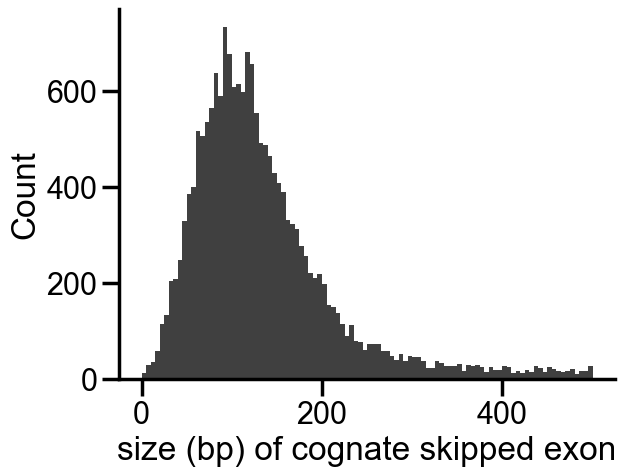

In [116]:

ax=sns.histplot(exclusion_event.SE_exon_length, color='black',linewidth=0, bins=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('size (bp) of cognate skipped exon')

Filter all events for clusters that fit the maxent scores
--

In [169]:
for_merge = protein_coding_genes_maxent_filtered_SE[['cluster_name'
    , 'strand', 'intron_1',
       'intron_2', 'majority_ss_1', 'minority_ss_1', 'minority_ss_2',
       'majority_ss_2', 'majority_ss_1_start', 'majority_ss_1_end',
       'majority_ss_2_start', 'majority_ss_2_end', 'minority_ss_1_start',
       'minority_ss_1_end', 'minority_ss_2_start', 'minority_ss_2_end',
       'majority_ss_1_seq', 'majority_ss_1_maxent_score', 'majority_ss_2_seq',
       'majority_ss_2_maxent_score', 'minority_ss_1_seq',
       'minority_ss_1_maxent_score', 'minority_ss_2_seq',
       'minority_ss_2_maxent_score', 'SE_exon_length', 'chromosome',
       'chrom_only_value', 'biotype', 'gene_name']]

all_EF_all_tissues_skipped_exons_protein_coding=all_EF_all_tissues_skipped_exons.merge(for_merge, on=['cluster_name']) 

In [170]:
all_EF_all_tissues_Alt_SS=all_EF_df_meets_five_percent_PSI_cutoff

for_merge = protein_coding_genes_maxent_filtered_AS[['cluster_name',
     'minority_ss', 'constant_ss', 'majority_ss',
       'ss_d', 'strand', 'splicing_event', 'minority_ss_start',
       'minority_ss_end', 'majority_ss_start', 'majority_ss_end',
       'constant_ss_start', 'constant_ss_end', 'constant_ss_seq',
       'constant_ss_maxent_score', 'minor_ss_seq', 'minority_ss_maxent_score',
       'major_ss_seq', 'majority_ss_maxent_score', 'exon_length', 'ss_c',
       'chromosome', 'chrom_only_value', 'biotype', 'gene_name']]

all_EF_all_tissues_alt_ss_protein_coding=all_EF_all_tissues_Alt_SS.merge(for_merge, on=['cluster_name'])



In [172]:
all_EF_all_tissues_alt_ss_protein_coding.to_csv(data_directory+'all_EF_all_tissues_alt_ss_protein_coding_w_canocial_ss.csv.gz',
                                                compression='gzip')

all_EF_all_tissues_skipped_exons_protein_coding.to_csv(data_directory+'all_EF_all_tissues_skipped_exons_protein_coding_w_canocial_ss.csv.gz',
                                                compression='gzip')

Filter for Max threshold in tissue
--

skipped exons


In [163]:
max_EF = 1 - (1/all_EF_all_tissues_alt_ss_protein_coding.number_people_in_sample)

all_EF_all_tissues_alt_ss_protein_coding=all_EF_all_tissues_alt_ss_protein_coding.assign( max_EF=max_EF)

In [164]:
max_EF = 1 - (1/all_EF_all_tissues_skipped_exons_protein_coding.number_people_in_sample)

all_EF_all_tissues_skipped_exons_protein_coding=all_EF_all_tissues_skipped_exons_protein_coding.assign( max_EF=max_EF)

NVEs_se = all_EF_all_tissues_skipped_exons_protein_coding[all_EF_all_tissues_skipped_exons_protein_coding.EF_5<=all_EF_all_tissues_skipped_exons_protein_coding.max_EF]

non_NVEs_se = all_EF_all_tissues_skipped_exons_protein_coding[all_EF_all_tissues_skipped_exons_protein_coding.EF_5>all_EF_all_tissues_skipped_exons_protein_coding.max_EF]


alt_ss


In [165]:
NVEs_alt_ss = all_EF_all_tissues_alt_ss_protein_coding[all_EF_all_tissues_alt_ss_protein_coding.EF_5<=all_EF_all_tissues_alt_ss_protein_coding.max_EF]

non_NVEs_alt_ss = all_EF_all_tissues_alt_ss_protein_coding[all_EF_all_tissues_alt_ss_protein_coding.EF_5>all_EF_all_tissues_alt_ss_protein_coding.max_EF]


export

In [149]:
NVEs_alt_ss.to_csv(data_directory+'all_NVEs_all_tissues_alt_ss_protein_coding.csv.gz',
                                                compression='gzip')

NVEs_se.to_csv(data_directory+'all_NVEs_all_tissues_skipped_exons_protein_coding.csv.gz',
                                                compression='gzip')

In [148]:
non_NVEs_alt_ss.to_csv(data_directory+'all_non_NVE_alt_splicing_all_tissues_alt_ss_protein_coding.csv.gz',
                                                compression='gzip')

non_NVEs_se.to_csv(data_directory+'all_non_NVE_alt_splicing_all_tissues_skipped_exons_protein_coding.csv.gz',
                                                compression='gzip')

top EF files

In [151]:
cluster_name=NVEs_alt_ss.intron_2.apply(lambda x: x.split(':clu_')[0])+'_'+NVEs_alt_ss.intron_1.apply(lambda x: x.split(':clu_')[0])

NVEs_alt_ss=NVEs_alt_ss.assign(cluster_name=cluster_name)

top_NVEs_alt_ss=NVEs_alt_ss.sort_values(by='EF_5',ascending=False).drop_duplicates(subset='cluster_name', keep='first')


top_NVEs_alt_ss.to_csv(data_directory+'filtered_maxent_top_EF_all_tissues_alt_ss.csv.gz', compression='gzip', index=False)








In [153]:
NVEs_se=NVEs_se.assign(intron_1=NVEs_se.intron_1_x)
NVEs_se=NVEs_se.assign(intron_2=NVEs_se.intron_2_x)

In [154]:
cluster_name=NVEs_se.intron_2.apply(lambda x: x.split(':clu_')[0])+'_'+NVEs_se.intron_1.apply(lambda x: x.split(':clu_')[0])

NVEs_se=NVEs_se.assign(cluster_name=cluster_name)

top_NVEs_se=NVEs_se.sort_values(by='EF_5',ascending=False).drop_duplicates(subset='cluster_name', keep='first')


top_NVEs_se.to_csv(data_directory+'filtered_maxent_top_EF_all_tissues_skipped_exons.csv.gz', compression='gzip', index=False)
